In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image, ImageOps
import pickle
import os

# Set seed for reproducibility
SEED = 50
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
class DataLoader:
    def __init__(self, train_size=5000, test_size=10000):
        self.train_size = train_size
        self.test_size = test_size
        self.x_train = None
        self.y_train = None
        self.x_test = None
        self.y_test = None
        self.class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
        self.load_data()
    
    def load_data(self):
        # Load and preprocess Fashion MNIST instead of MNIST
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
        
        # Normalization
        x_train = x_train.reshape(-1, 784).astype(np.float32) / 255.0
        x_test = x_test.reshape(-1, 784).astype(np.float32) / 255.0
        
        # One-Hot-Encoding
        y_train = tf.keras.utils.to_categorical(y_train, 10)
        y_test = tf.keras.utils.to_categorical(y_test, 10)
        
        # Training Set
        self.x_train = x_train[:self.train_size]
        self.y_train = y_train[:self.train_size]
        
        # Testing Set
        self.x_test = x_test[:self.test_size]
        self.y_test = y_test[:self.test_size]
    
    def get_data(self):
        return self.x_train, self.y_train, self.x_test, self.y_test
    
    def get_samples(self, num_samples=5):
        # Get random samples for visualization 
        indices = np.random.choice(len(self.x_test), num_samples, replace=False)
        return self.x_test[indices], self.y_test[indices], indices

In [4]:
class NeuralNetwork:
    def __init__(self, input_dim=784, hidden_dim=32, output_dim=10):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.W1 = None
        self.b1 = None
        self.W2 = None
        self.b2 = None
        self.vector_size = input_dim * hidden_dim + hidden_dim + hidden_dim * output_dim + output_dim
        self.initialize_weights()
    
    def initialize_weights(self):
        # Initialize the model's parameters inside the class, so that they can be used during forward or backward passes.
        self.W1 = np.random.randn(self.input_dim, self.hidden_dim) * np.sqrt(2 / self.input_dim)
        self.b1 = np.zeros(self.hidden_dim)
        self.W2 = np.random.randn(self.hidden_dim, self.output_dim) * np.sqrt(2 / self.hidden_dim)
        self.b2 = np.zeros(self.output_dim)
    
    def he_vector(self):
        """Generate a vector using He initialization"""
        # Generate a vector representing a possible solution (for optimization algorithms like Genetic Algorithms, Differential Evolution, etc.)
        w1 = np.random.randn(self.input_dim, self.hidden_dim) * np.sqrt(2 / self.input_dim)
        b1 = np.zeros(self.hidden_dim)
        w2 = np.random.randn(self.hidden_dim, self.output_dim) * np.sqrt(2 / self.hidden_dim)
        b2 = np.zeros(self.output_dim)
        return np.concatenate([w1.flatten(), b1, w2.flatten(), b2])
    
    def decode_vector(self, vector):
        """Decode a flat vector into the network weights"""
        W1 = vector[0:self.input_dim * self.hidden_dim].reshape((self.input_dim, self.hidden_dim))
        b1 = vector[self.input_dim * self.hidden_dim:self.input_dim * self.hidden_dim + self.hidden_dim].reshape((self.hidden_dim,))
        W2 = vector[self.input_dim * self.hidden_dim + self.hidden_dim:self.input_dim * self.hidden_dim + self.hidden_dim + self.hidden_dim * self.output_dim].reshape((self.hidden_dim, self.output_dim))
        b2 = vector[self.input_dim * self.hidden_dim + self.hidden_dim + self.hidden_dim * self.output_dim:].reshape((self.output_dim,))
        return W1, b1, W2, b2
    
    def set_weights_from_vector(self, vector):
        """Set the network weights from a flat vector"""
        self.W1, self.b1, self.W2, self.b2 = self.decode_vector(vector)
    
    def get_weights_as_vector(self):
        """Convert the network weights to a flat vector"""
        return np.concatenate([self.W1.flatten(), self.b1, self.W2.flatten(), self.b2])
    
    def relu(self, x):
        """ReLU activation function"""
        return np.maximum(0, x)
    
    def softmax(self, x):
        """Softmax activation function with numerical stability"""
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e_x / np.sum(e_x, axis=1, keepdims=True)
    
    def forward(self, X):
        """Forward pass through the network (for backpropagation)"""  
        Z1 = X @ self.W1 + self.b1      # Linear part
        A1 = self.relu(Z1)              # Apply ReLU
        Z2 = A1 @ self.W2 + self.b2     # Linear part
        A2 = self.softmax(Z2)           # Apply softmax
        return A2, A1, Z1
    
    def forward_from_vector(self, X, vector):
        """Forward pass using weights from a vector (for EA)"""
        W1, b1, W2, b2 = self.decode_vector(vector)
        Z1 = X @ W1 + b1      # Linear part
        A1 = self.relu(Z1)    # Apply ReLU
        Z2 = A1 @ W2 + b2     # Linear part
        A2 = self.softmax(Z2) # Apply softmax
        return A2
    
    def cross_entropy(self, preds, targets, eps=1e-12):
        """Compute cross-entropy loss"""
        preds = np.clip(preds, eps, 1 - eps)  # Avoid log(0) and log(1)
        return -np.mean(np.sum(targets * np.log(preds), axis=1))
    
    def predict(self, X):
        """Make predictions for input data"""
        probs, _, _ = self.forward(X)
        return np.argmax(probs, axis=1)
    
    def evaluate(self, X, y):
        """Evaluate model performance"""
        probs, _, _ = self.forward(X)
        loss = self.cross_entropy(probs, y)
        y_pred = np.argmax(probs, axis=1)
        y_true = np.argmax(y, axis=1)
        accuracy = np.mean(y_pred == y_true)
        return loss, accuracy
    
    def fitness_function(self, vector, x_data, y_data):
        """Compute the fitness (loss) for a given weight vector"""
        probs = self.forward_from_vector(x_data, vector)
        ce_loss = self.cross_entropy(probs, y_data)
        return ce_loss
    
    def save_model(self, filename):
        """Save the model weights to a file"""
        model_data = {
            'W1': self.W1,
            'b1': self.b1,
            'W2': self.W2,
            'b2': self.b2,
            'input_dim': self.input_dim,
            'hidden_dim': self.hidden_dim,
            'output_dim': self.output_dim
        }
        with open(filename, 'wb') as f:
            pickle.dump(model_data, f)
    
    @classmethod
    def load_model(cls, filename):
        """Load a model from a file"""
        with open(filename, 'rb') as f:
            model_data = pickle.load(f)
        
        model = cls(
            input_dim=model_data['input_dim'],
            hidden_dim=model_data['hidden_dim'],
            output_dim=model_data['output_dim']
        )
        
        model.W1 = model_data['W1']
        model.b1 = model_data['b1']
        model.W2 = model_data['W2']
        model.b2 = model_data['b2']
        
        return model

In [5]:

class Visualizer:
    def __init__(self, model, data_loader):
        self.model = model
        self.data_loader = data_loader
    
    def display_results_table(self, results):
        """Display a table with performance metrics"""
        table_data = {
            'Metric': ['Best Loss', 'Final Loss', 'Final Test Accuracy', 'Total Iterations', 'Execution Time (s)'],
            'Value': [
                f"{results['best_loss']:.4f}",
                f"{results['final_loss']:.4f}",
                f"{results['final_accuracy']:.4f}",
                f"{results['total_iterations']}",
                f"{results['execution_time']:.2f}"
            ]
        }
        
        print("\nPerformance Summary:")
        print("-" * 40)
        for i in range(len(table_data['Metric'])):
            print(f"{table_data['Metric'][i]:<20}: {table_data['Value'][i]}")
        print("-" * 40)
        
        return table_data
    
    def plot_training_progress(self, history):
        """Plot the training progress (loss and accuracy)"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot loss
        ax1.plot(history['loss'], label='Training Loss')
        ax1.plot(history['val_loss'], label='Validation Loss')
        ax1.set_title('Loss over Iterations')
        ax1.set_xlabel('Iteration')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracy
        ax2.plot(history['accuracy'], label='Training Accuracy')
        ax2.plot(history['val_accuracy'], label='Validation Accuracy')
        ax2.set_title('Accuracy over Iterations')
        ax2.set_xlabel('Iteration')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def plot_confusion_matrix(self):
        """Plot the confusion matrix for the test data"""
        _, _, x_test, y_test = self.data_loader.get_data()
        y_pred = self.model.predict(x_test)
        y_true = np.argmax(y_test, axis=1)
        
        cm = confusion_matrix(y_true, y_pred)
        
        # Plot with class names for Fashion MNIST
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=self.data_loader.class_names,
                   yticklabels=self.data_loader.class_names)
        plt.title('Confusion Matrix - Fashion MNIST')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
    
    def display_classification_report(self):
        """Display the classification report"""
        _, _, x_test, y_test = self.data_loader.get_data()
        y_pred = self.model.predict(x_test)
        y_true = np.argmax(y_test, axis=1)
        
        # Create classification report with Fashion MNIST class names
        report = classification_report(y_true, y_pred, 
                                      target_names=self.data_loader.class_names,
                                      digits=4)
        print("\nClassification Report:")
        print(report)
        
        # Create a DataFrame for visualization
        report_data = classification_report(y_true, y_pred, 
                                          target_names=self.data_loader.class_names,
                                          digits=4, output_dict=True)
        df_report = pd.DataFrame(report_data).transpose()
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(df_report.iloc[:-3, :].astype(float), annot=True, cmap='Blues')
        plt.title('Classification Report - Fashion MNIST')
        plt.tight_layout()
        plt.show()

    def display_samples(self, num_samples=5):
        """Display sample images with actual and predicted labels"""
        x_samples, y_samples, indices = self.data_loader.get_samples(num_samples)
        y_true = np.argmax(y_samples, axis=1)
        y_pred = self.model.predict(x_samples)
        
        plt.figure(figsize=(15, 3))
        for i in range(num_samples):
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(x_samples[i].reshape(28, 28), cmap='gray')
            true_label = self.data_loader.class_names[y_true[i]]
            pred_label = self.data_loader.class_names[y_pred[i]]
            plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=9)
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    def visualize_all(self, results):
        """Run all visualization methods"""
        self.display_results_table(results)
        self.plot_training_progress(results['history'])
        self.plot_confusion_matrix()
        self.display_classification_report()
        self.display_samples()

In [6]:
class DifferentialEvolution:
    def __init__(self, model, data_loader, pop_size=20, generations=5000, F=0.5, CR=0.7, initial_population=None, initial_fitness=None):
        self.model = model
        self.data_loader = data_loader
        self.pop_size = pop_size
        self.generations = generations
        self.F = F
        self.CR = CR
        self.dim = model.vector_size
        self.population = initial_population
        self.fitness = initial_fitness
        self.history = {
            'loss': [],
            'accuracy': [],
            'val_loss': [],
            'val_accuracy': [],
            'population_states': []
        }
    
    def train(self):
        start_time = time.time()
        x_train, y_train, x_test, y_test = self.data_loader.get_data()
        
        # Initialize population
        if self.population is None or self.fitness is None:
            population = np.array([self.model.he_vector() for _ in range(self.pop_size)])
            fitness = np.array([self.model.fitness_function(ind, x_train, y_train) for ind in population])
        else:
            population = np.array(self.population)
            fitness = np.array(self.fitness)
        
        print(f"Starting Differential Evolution for {self.generations} generations on Fashion MNIST...")
        
        for gen in range(self.generations):
            # To store offsprings
            new_pop = np.zeros_like(population)
            new_fit = np.zeros(self.pop_size)
            
            for i in range(self.pop_size):
                # Parent Selection
                idxs = np.delete(np.arange(self.pop_size), i)  # Target Vector
                
                # current/1 Mutation
                v1, v2, v3 = population[np.random.choice(idxs, 3, replace=False)]
                mutant = v1 + self.F * (v2 - v3)  # Mutant Vector
                
                # Crossover
                cross_points = np.random.rand(self.dim) < self.CR
                if not np.any(cross_points):
                    cross_points[np.random.randint(self.dim)] = True
                
                trial = np.where(cross_points, mutant, population[i])
                trial_fitness = self.model.fitness_function(trial, x_train, y_train)
                
                # Survivor Selection
                if trial_fitness <= fitness[i]:
                    new_pop[i] = trial
                    new_fit[i] = trial_fitness
                else:
                    new_pop[i] = population[i]
                    new_fit[i] = fitness[i]
            
            population = np.array(new_pop)
            fitness = np.array(new_fit)
            
            # Find best solution
            best_idx = np.argmin(fitness)
            best_solution = population[best_idx]
            best_loss = fitness[best_idx]
            
            # Update model with best solution and evaluate
            self.model.set_weights_from_vector(best_solution)
            train_loss, train_accuracy = self.model.evaluate(x_train, y_train)
            val_loss, val_accuracy = self.model.evaluate(x_test, y_test)
            
            # Store metrics
            self.history['loss'].append(train_loss)
            self.history['accuracy'].append(train_accuracy)
            self.history['val_loss'].append(val_loss)
            self.history['val_accuracy'].append(val_accuracy)
            
            # Store population state every 500 generations
            if gen % 500 == 0 or gen == self.generations - 1:
                self.history['population_states'].append({
                    'generation': gen,
                    'population': population.copy(),
                    'fitness': fitness.copy()
                })
            
            if gen % 100 == 0 or gen == self.generations - 1:
                print(f"Generation {gen+1}/{self.generations} - Best loss: {best_loss:.4f} - Accuracy: {val_accuracy:.4f}")
        
        # Set final best solution to the model
        best_idx = np.argmin(fitness)
        best_solution = population[best_idx]
        self.model.set_weights_from_vector(best_solution)
        
        execution_time = time.time() - start_time
        
        final_train_loss, final_train_accuracy = self.model.evaluate(x_train, y_train)
        final_val_loss, final_val_accuracy = self.model.evaluate(x_test, y_test)
        
        result = {
            'best_loss': min(self.history['val_loss']),
            'final_loss': final_val_loss,
            'final_accuracy': final_val_accuracy,
            'total_iterations': self.generations,
            'execution_time': execution_time,
            'history': self.history
        }
        
        return result

In [7]:
def run_differential_evolution(initial_population=None, initial_fitness=None):
    """Main function to run the Differential Evolution algorithm on Fashion MNIST dataset"""
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    print("Running Neural Network with Differential Evolution optimization on Fashion MNIST...")
    
    # Initialize data loader
    data_loader = DataLoader()
    
    # Initialize neural network
    model = NeuralNetwork(input_dim=784, hidden_dim=32, output_dim=10)
    
    # Initialize DE optimizer
    de_optimizer = DifferentialEvolution(model, data_loader, pop_size=20, generations=3000, F=0.5, CR=0.7, initial_population=initial_population, initial_fitness=initial_fitness)
    
    # Train the model
    results = de_optimizer.train()
    
    # Save the model
    model.save_model('fashion_mnist_de_model.pkl')
    
    # Visualize results
    visualizer = Visualizer(model, data_loader)
    visualizer.visualize_all(results)
    
    return model, results

Running Neural Network with Differential Evolution optimization on Fashion MNIST...
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Starting Differential Evolution for 3000 generations on Fashion MNIST...
Generation 1/3000 - Best loss: 2.2899 - Accuracy: 0.1425
Generation 101/3000 - Best loss: 1.9710 - Accuracy: 0.2777
Generation 201/3000 - Best loss: 1.8626 - Accuracy: 0.3665
Generation 301/3000 - Best loss: 1.7029 - Accuracy: 0.3955
Generation 401/3000 - Best loss: 1.6900 - Accuracy: 0.4267
Generation 501/3000 - Best loss: 1.6900 - Accuracy: 0.4267
Generation 601/3000 - Best loss: 1.6223 - Accuracy: 0.3737
Generation 701/3000 - Best loss: 1.5060 - Accuracy: 0.4705
Generation 801/3000 - Best loss: 1.3575 - Accuracy: 0.4844
Generation 901/3000 - Best loss: 1.1558 - Accuracy: 0.5607
Generation 1001/3000 - Best loss: 1.0583 - Accuracy: 0.5993
Generat

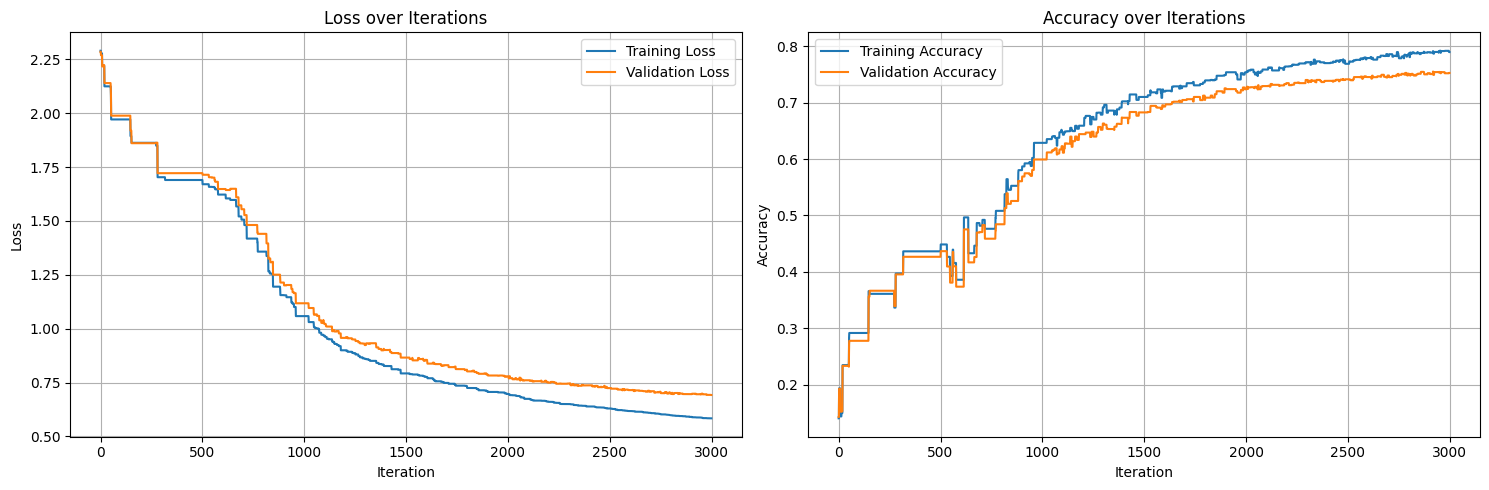

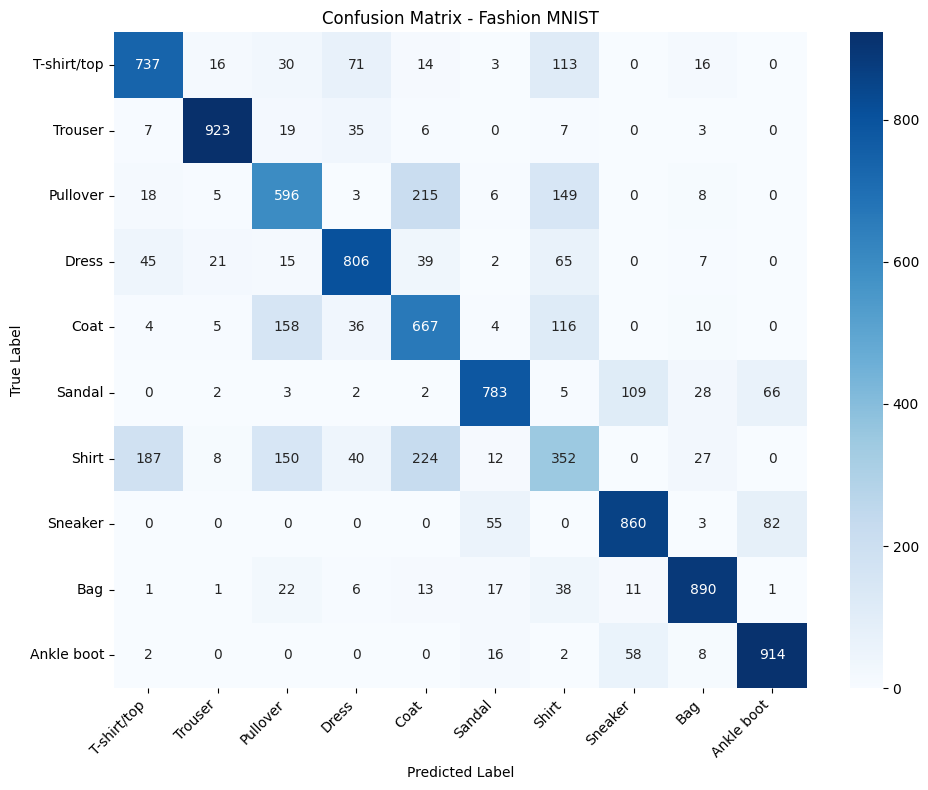


Classification Report:
              precision    recall  f1-score   support

 T-shirt/top     0.7363    0.7370    0.7366      1000
     Trouser     0.9409    0.9230    0.9319      1000
    Pullover     0.6002    0.5960    0.5981      1000
       Dress     0.8068    0.8060    0.8064      1000
        Coat     0.5653    0.6670    0.6119      1000
      Sandal     0.8719    0.7830    0.8251      1000
       Shirt     0.4156    0.3520    0.3812      1000
     Sneaker     0.8285    0.8600    0.8440      1000
         Bag     0.8900    0.8900    0.8900      1000
  Ankle boot     0.8598    0.9140    0.8861      1000

    accuracy                         0.7528     10000
   macro avg     0.7515    0.7528    0.7511     10000
weighted avg     0.7515    0.7528    0.7511     10000



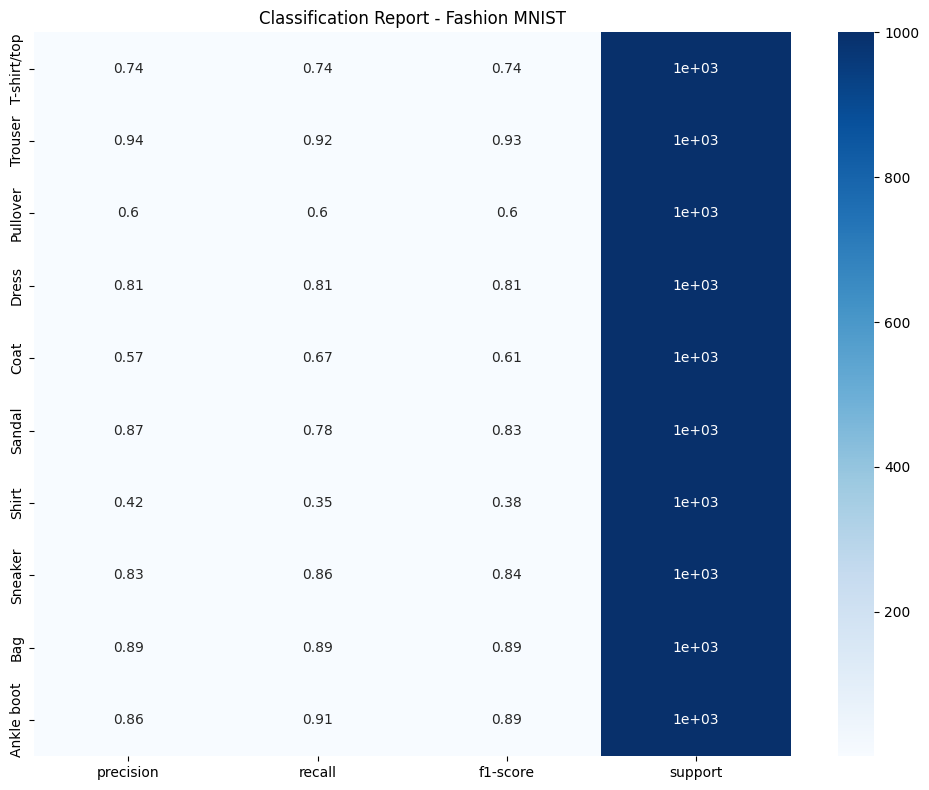

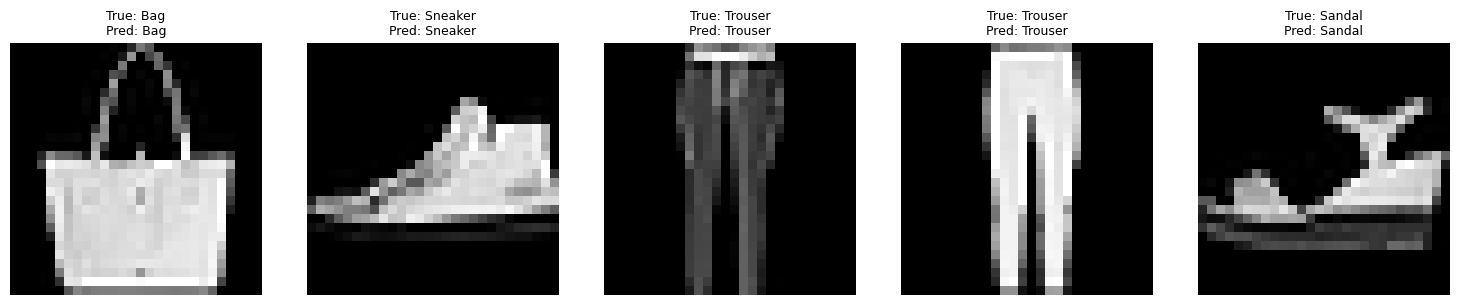

(<__main__.NeuralNetwork at 0x7adc4af5c690>,
 {'best_loss': 0.6922301271478808,
  'final_loss': 0.6922301271478808,
  'final_accuracy': 0.7528,
  'total_iterations': 3000,
  'execution_time': 1017.4598133563995,
  'history': {'loss': [2.2899047433569293,
    2.2899047433569293,
    2.277808938198729,
    2.277808938198729,
    2.277808938198729,
    2.277808938198729,
    2.277808938198729,
    2.277808938198729,
    2.2236571847024496,
    2.2236571847024496,
    2.2236571847024496,
    2.2236571847024496,
    2.2236571847024496,
    2.2236571847024496,
    2.2196095187916973,
    2.2196095187916973,
    2.2196095187916973,
    2.2196095187916973,
    2.2196095187916973,
    2.1246081013525933,
    2.1246081013525933,
    2.1246081013525933,
    2.1246081013525933,
    2.1246081013525933,
    2.1246081013525933,
    2.1246081013525933,
    2.1246081013525933,
    2.1246081013525933,
    2.1246081013525933,
    2.1246081013525933,
    2.1246081013525933,
    2.1246081013525933,
    2.1

In [8]:
run_differential_evolution()

In [9]:
class JADE:
    def __init__(self, model, data_loader, pop_size=20, generations=5000, p=0.2, c=0.05):
        self.model = model
        self.data_loader = data_loader
        self.pop_size = pop_size
        self.generations = generations
        self.p = p
        self.c = c
        self.dim = model.vector_size
        self.history = {
            'loss': [],
            'accuracy': [],
            'val_loss': [],
            'val_accuracy': [],
            'population_states': []
        }
    
    def train(self):
        start_time = time.time()
        x_train, y_train, x_test, y_test = self.data_loader.get_data()
        
        # Initialize population using He initialization
        population = np.array([self.model.he_vector() for _ in range(self.pop_size)])
        fitness = np.array([self.model.fitness_function(ind, x_train, y_train) for ind in population])
        archive = []
        mu_F, mu_CR = 0.5, 0.5  # Initial means
        
        print(f"Starting JADE optimization for {self.generations} generations on Fashion MNIST...")
        
        for gen in range(self.generations):
            successful_F, successful_CR, deltas = [], [], []
            
            sorted_indices = np.argsort(fitness)
            p_num = max(2, int(self.p * self.pop_size))
            top_indices = sorted_indices[:p_num]
            
            for i in range(self.pop_size):
                # Sample F (mutation factor) from a Cauchy distribution
                F = np.clip(np.random.standard_cauchy() * 0.1 + mu_F, 0, 1)
                while F <= 0:  # Ensure F > 0
                    F = np.clip(np.random.standard_cauchy() * 0.1 + mu_F, 0, 1)
                
                # Sample CR (crossover rate) from a normal distribution
                CR = np.clip(np.random.normal(mu_CR, 0.1), 0, 1)
                
                # Select p-best individual
                pbest = population[np.random.choice(top_indices)]
                
                # Select r1 and r2
                r1 = np.random.choice(np.delete(np.arange(self.pop_size), i))
                
                merged = np.vstack([population, archive]) if len(archive) > 0 else population
                r2_index = np.random.randint(0, len(merged))
                r2 = merged[r2_index]
                
                x_i, x_r1, x_r2 = population[i], population[r1], r2
                
                # Mutation: current-to-pbest
                v = x_i + F * (pbest - x_i) + F * (x_r1 - x_r2)
                
                # Crossover
                cross_mask = np.random.rand(self.dim) < CR
                if not np.any(cross_mask):
                    cross_mask[np.random.randint(self.dim)] = True
                u = np.where(cross_mask, v, x_i)
                
                # Selection
                fit_u = self.model.fitness_function(u, x_train, y_train)
                if fit_u <= fitness[i]:
                    archive.append(population[i].copy())
                    if len(archive) > self.pop_size:
                        archive.pop(np.random.randint(len(archive)))
                    
                    population[i] = u
                    deltas.append(abs(fitness[i] - fit_u))
                    fitness[i] = fit_u
                    successful_F.append(F)
                    successful_CR.append(CR)
            
            # Adapt mu_F and mu_CR using successful values
            if successful_F:
                weights = np.array(deltas) / np.sum(deltas)
                F_array = np.array(successful_F)
                mu_F = (1 - self.c) * mu_F + self.c * np.sum(weights * F_array ** 2) / np.sum(weights * F_array)
            
            if successful_CR:
                mu_CR = (1 - self.c) * mu_CR + self.c * np.mean(successful_CR)
            
            # Log best loss every generation
            best_idx = np.argmin(fitness)
            best_solution = population[best_idx]
            best_loss = fitness[best_idx]
            
            # Update model with best solution and evaluate
            self.model.set_weights_from_vector(best_solution)
            train_loss, train_accuracy = self.model.evaluate(x_train, y_train)
            val_loss, val_accuracy = self.model.evaluate(x_test, y_test)
            
            # Store metrics
            self.history['loss'].append(train_loss)
            self.history['accuracy'].append(train_accuracy)
            self.history['val_loss'].append(val_loss)
            self.history['val_accuracy'].append(val_accuracy)
            
            # Store population state every 500 generations
            if gen % 500 == 0 or gen == self.generations - 1:
                self.history['population_states'].append({
                    'generation': gen,
                    'population': population.copy(),
                    'fitness': fitness.copy()
                })
            
            if gen % 100 == 0 or gen == self.generations - 1:
                print(f"Generation {gen+1}/{self.generations} - Best loss: {best_loss:.4f} - Accuracy: {val_accuracy:.4f}")
        
        # Set final best solution to the model
        best_idx = np.argmin(fitness)
        best_solution = population[best_idx]
        self.model.set_weights_from_vector(best_solution)
        
        execution_time = time.time() - start_time
        
        final_train_loss, final_train_accuracy = self.model.evaluate(x_train, y_train)
        final_val_loss, final_val_accuracy = self.model.evaluate(x_test, y_test)
        
        result = {
            'best_loss': min(self.history['val_loss']),
            'final_loss': final_val_loss,
            'final_accuracy': final_val_accuracy,
            'total_iterations': self.generations,
            'execution_time': execution_time,
            'history': self.history
        }
        
        return result

In [10]:
def run_jade():
    """Main function to run the JADE algorithm on Fashion MNIST dataset"""
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    print("Running Neural Network with JADE optimization on Fashion MNIST...")
    
    # Initialize data loader
    data_loader = DataLoader()
    
    # Initialize neural network
    model = NeuralNetwork(input_dim=784, hidden_dim=32, output_dim=10)
    
    # Initialize JADE optimizer
    jade_optimizer = JADE(model, data_loader, pop_size=20, generations=3000, p=0.2, c=0.05)
    
    # Train the model
    results = jade_optimizer.train()
    
    # Save the model
    model.save_model('fashion_mnist_jade_model.pkl')
    
    # Visualize results
    visualizer = Visualizer(model, data_loader)
    visualizer.visualize_all(results)
    
    return model, results

Running Neural Network with JADE optimization on Fashion MNIST...
Starting JADE optimization for 3000 generations on Fashion MNIST...
Generation 1/3000 - Best loss: 2.2899 - Accuracy: 0.1425
Generation 101/3000 - Best loss: 1.2382 - Accuracy: 0.5814
Generation 201/3000 - Best loss: 0.9071 - Accuracy: 0.6693
Generation 301/3000 - Best loss: 0.8158 - Accuracy: 0.6961
Generation 401/3000 - Best loss: 0.7390 - Accuracy: 0.7176
Generation 501/3000 - Best loss: 0.6875 - Accuracy: 0.7311
Generation 601/3000 - Best loss: 0.6614 - Accuracy: 0.7432
Generation 701/3000 - Best loss: 0.6386 - Accuracy: 0.7473
Generation 801/3000 - Best loss: 0.6215 - Accuracy: 0.7518
Generation 901/3000 - Best loss: 0.6052 - Accuracy: 0.7597
Generation 1001/3000 - Best loss: 0.5883 - Accuracy: 0.7621
Generation 1101/3000 - Best loss: 0.5704 - Accuracy: 0.7651
Generation 1201/3000 - Best loss: 0.5593 - Accuracy: 0.7660
Generation 1301/3000 - Best loss: 0.5509 - Accuracy: 0.7710
Generation 1401/3000 - Best loss: 0.54

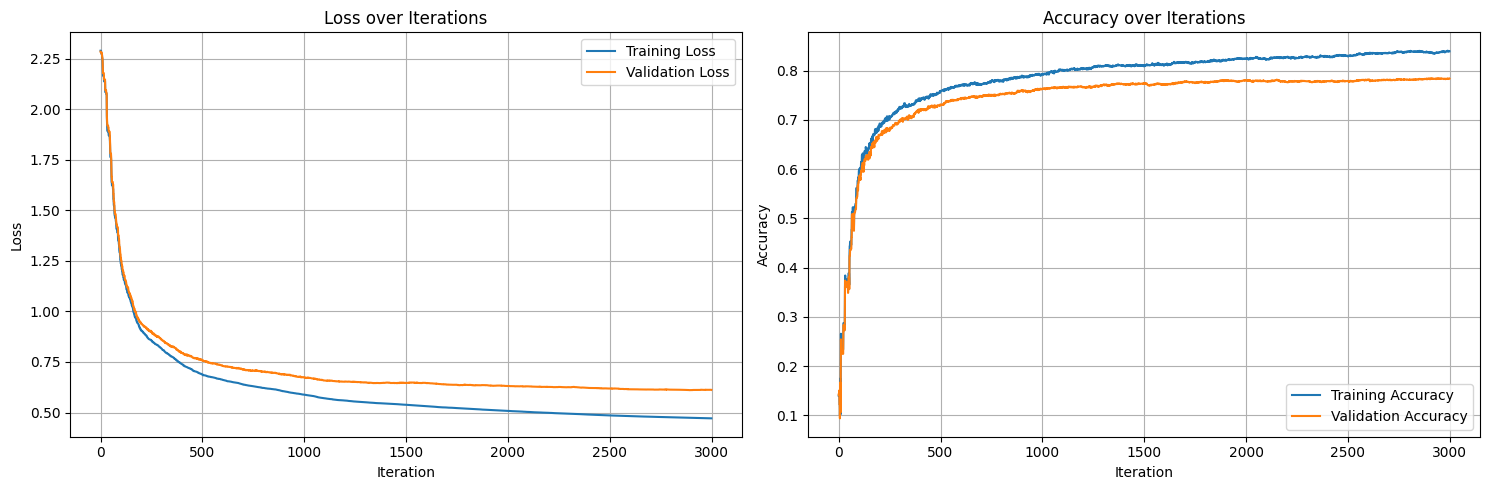

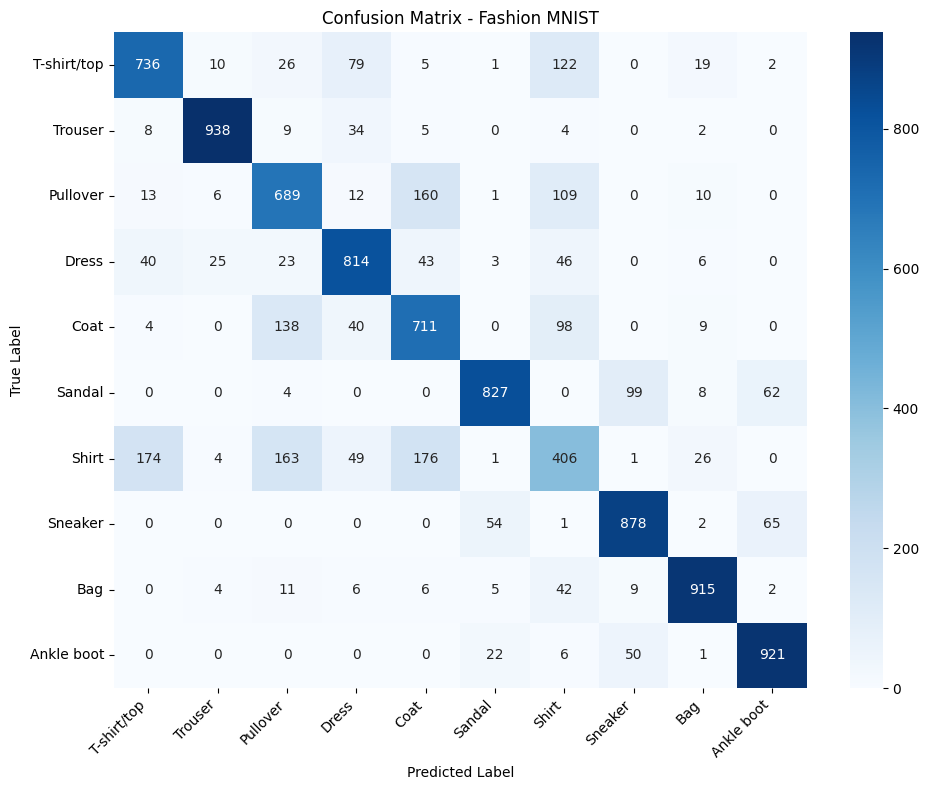


Classification Report:
              precision    recall  f1-score   support

 T-shirt/top     0.7549    0.7360    0.7453      1000
     Trouser     0.9504    0.9380    0.9441      1000
    Pullover     0.6482    0.6890    0.6680      1000
       Dress     0.7872    0.8140    0.8004      1000
        Coat     0.6429    0.7110    0.6752      1000
      Sandal     0.9048    0.8270    0.8642      1000
       Shirt     0.4868    0.4060    0.4427      1000
     Sneaker     0.8467    0.8780    0.8621      1000
         Bag     0.9168    0.9150    0.9159      1000
  Ankle boot     0.8755    0.9210    0.8977      1000

    accuracy                         0.7835     10000
   macro avg     0.7814    0.7835    0.7816     10000
weighted avg     0.7814    0.7835    0.7816     10000



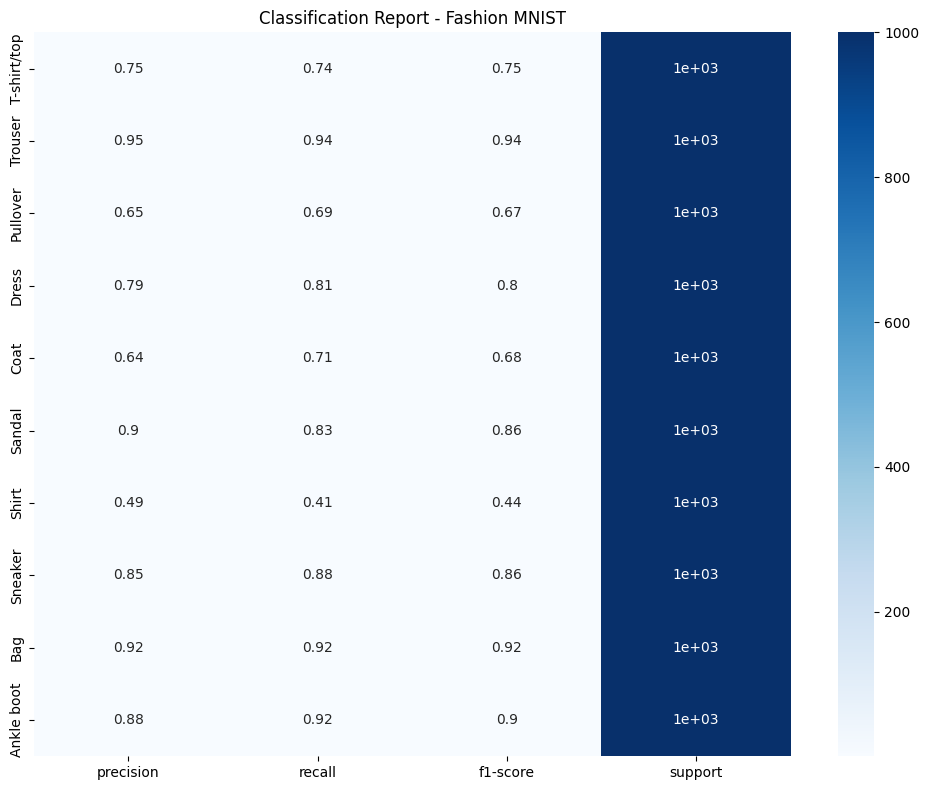

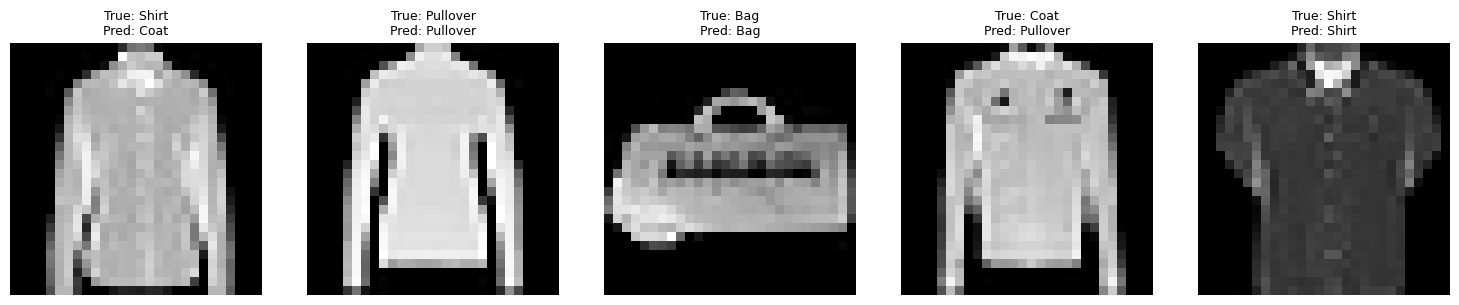

(<__main__.NeuralNetwork at 0x7adc4742ccd0>,
 {'best_loss': 0.6104965060667071,
  'final_loss': 0.6120799791996726,
  'final_accuracy': 0.7835,
  'total_iterations': 3000,
  'execution_time': 1164.5088455677032,
  'history': {'loss': [2.2899047433569293,
    2.2899047433569293,
    2.2899047433569293,
    2.285402122267057,
    2.274737112277711,
    2.274737112277711,
    2.274436943641334,
    2.270481437793598,
    2.2525566228873526,
    2.249805398663495,
    2.230130255369816,
    2.1967841474438097,
    2.166368334457205,
    2.166368334457205,
    2.166368334457205,
    2.166368334457205,
    2.166368334457205,
    2.1380936366525574,
    2.1380936366525574,
    2.1380936366525574,
    2.1380936366525574,
    2.1380936366525574,
    2.1380936366525574,
    2.085217037137575,
    2.085217037137575,
    2.085217037137575,
    2.085217037137575,
    2.085217037137575,
    2.077150712794587,
    2.077150712794587,
    2.069547116771439,
    1.9544316350361373,
    1.927591067893440

In [11]:
run_jade()